In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import joblib    
import pickle
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=40

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Ishita\IGDTUW (CSE)\Summer Internship 2023\Potato",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1500 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

47

(32, 256, 256, 3)
[0 1 1 2 1 2 1 0 1 0 0 2 1 2 1 0 0 1 2 1 2 0 0 1 2 0 0 0 1 2 0 1]


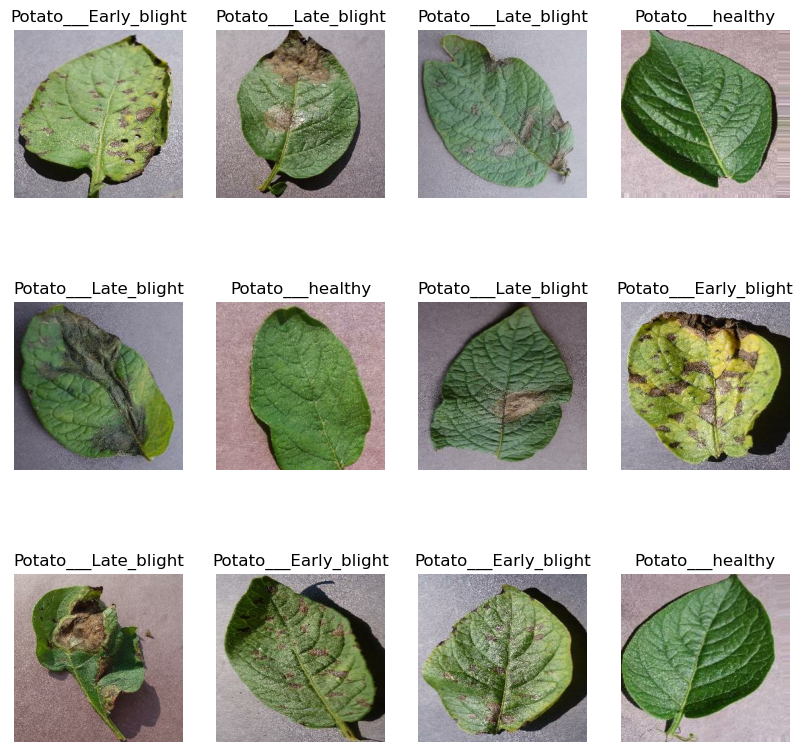

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [8]:
print(len(train_ds), len(val_ds), len(test_ds))

37 4 6


In [9]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/40
37/37 [==============================] - 45s 1s/step - loss: 1.0789 - accuracy: 0.3915 - val_loss: 0.8144 - val_accuracy: 0.6250
Epoch 2/40
37/37 [==============================] - 45s 1s/step - loss: 0.5494 - accuracy: 0.7424 - val_loss: 0.3859 - val_accuracy: 0.8594
Epoch 3/40
37/37 [==============================] - 46s 1s/step - loss: 0.4188 - accuracy: 0.8220 - val_loss: 0.2844 - val_accuracy: 0.8672
Epoch 4/40
37/37 [==============================] - 45s 1s/step - loss: 0.3270 - accuracy: 0.8678 - val_loss: 0.2192 - val_accuracy: 0.9062
Epoch 5/40
37/37 [==============================] - 45s 1s/step - loss: 0.2656 - accuracy: 0.8915 - val_loss: 0.2429 - val_accuracy: 0.8750
Epoch 6/40
37/37 [==============================] - 47s 1s/step - loss: 0.2933 - accuracy: 0.8814 - val_loss: 0.3324 - val_accuracy: 0.8750
Epoch 7/40
37/37 [==============================] - 48s 1s/step - loss: 0.2606 - accuracy: 0.8949 - val_loss: 0.2246 - val_accuracy: 0.8906
Epoch 8/40
37/37 [==

In [13]:
scores=model.evaluate(test_ds)
scores

6/6 [==============================] - 3s 219ms/step - loss: 0.0335 - accuracy: 0.9896


[0.033482521772384644, 0.9895833134651184]

In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [15]:
history.history['loss']

[1.0789121389389038,
 0.5493739247322083,
 0.4187770485877991,
 0.32703036069869995,
 0.265618234872818,
 0.29334425926208496,
 0.26056763529777527,
 0.19444340467453003,
 0.17992658913135529,
 0.18241553008556366,
 0.15132491290569305,
 0.17229317128658295,
 0.1889880895614624,
 0.176685631275177,
 0.14798252284526825,
 0.14337985217571259,
 0.1132122203707695,
 0.20069605112075806,
 0.13709047436714172,
 0.11547145247459412,
 0.10439296811819077,
 0.1579541265964508,
 0.12250158190727234,
 0.12628412246704102,
 0.10982692986726761,
 0.12425926327705383,
 0.11385414004325867,
 0.059802860021591187,
 0.05830909684300423,
 0.09281820058822632,
 0.08537542074918747,
 0.0843493640422821,
 0.12376971542835236,
 0.10049377381801605,
 0.08965841680765152,
 0.050907254219055176,
 0.0463954359292984,
 0.05167296901345253,
 0.04356516897678375,
 0.08301103115081787]

In [16]:
history.history['accuracy']

[0.39152541756629944,
 0.7423728704452515,
 0.8220338821411133,
 0.8677965998649597,
 0.8915254473686218,
 0.8813559412956238,
 0.8949152827262878,
 0.9245762825012207,
 0.9389830231666565,
 0.9313559532165527,
 0.944915235042572,
 0.9355932474136353,
 0.9271186590194702,
 0.9338983297348022,
 0.946610152721405,
 0.941525399684906,
 0.9559321999549866,
 0.9220339059829712,
 0.9457626938819885,
 0.9542372822761536,
 0.9677966237068176,
 0.9389830231666565,
 0.9584745764732361,
 0.951694905757904,
 0.9542372822761536,
 0.9542372822761536,
 0.9601694941520691,
 0.9779661297798157,
 0.9822033643722534,
 0.9669491648674011,
 0.9669491648674011,
 0.9711864590644836,
 0.951694905757904,
 0.9644067883491516,
 0.9669491648674011,
 0.9788135886192322,
 0.9864406585693359,
 0.9779661297798157,
 0.9847457408905029,
 0.9694915413856506]

In [17]:
history.history['val_loss']

[0.8143672347068787,
 0.3859381079673767,
 0.2843691110610962,
 0.2191663384437561,
 0.2429153025150299,
 0.33240893483161926,
 0.22464439272880554,
 0.16774886846542358,
 0.161956325173378,
 0.20880717039108276,
 0.1394808292388916,
 0.22622422873973846,
 0.10880831629037857,
 0.3480225205421448,
 0.1213698610663414,
 0.1520267277956009,
 0.15309593081474304,
 0.14622581005096436,
 0.05898461490869522,
 0.12379425764083862,
 0.27100682258605957,
 0.11023527383804321,
 0.23021715879440308,
 0.09089212119579315,
 0.11559492349624634,
 0.051125869154930115,
 0.1596042513847351,
 0.04644078388810158,
 0.18475057184696198,
 0.06786610186100006,
 0.30429360270500183,
 0.09342408180236816,
 0.05476492643356323,
 0.03143875673413277,
 0.14843569695949554,
 0.038893163204193115,
 0.0404089093208313,
 0.039046790450811386,
 0.13024578988552094,
 0.03341168537735939]

In [18]:
history.history['val_accuracy']

[0.625,
 0.859375,
 0.8671875,
 0.90625,
 0.875,
 0.875,
 0.890625,
 0.921875,
 0.9453125,
 0.90625,
 0.9453125,
 0.8984375,
 0.953125,
 0.875,
 0.9453125,
 0.9296875,
 0.9296875,
 0.953125,
 0.9765625,
 0.9609375,
 0.9140625,
 0.953125,
 0.921875,
 0.9609375,
 0.9453125,
 0.9921875,
 0.9453125,
 0.984375,
 0.9375,
 0.9765625,
 0.8984375,
 0.9609375,
 0.984375,
 0.984375,
 0.9296875,
 0.984375,
 0.9765625,
 0.984375,
 0.953125,
 0.984375]

In [19]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

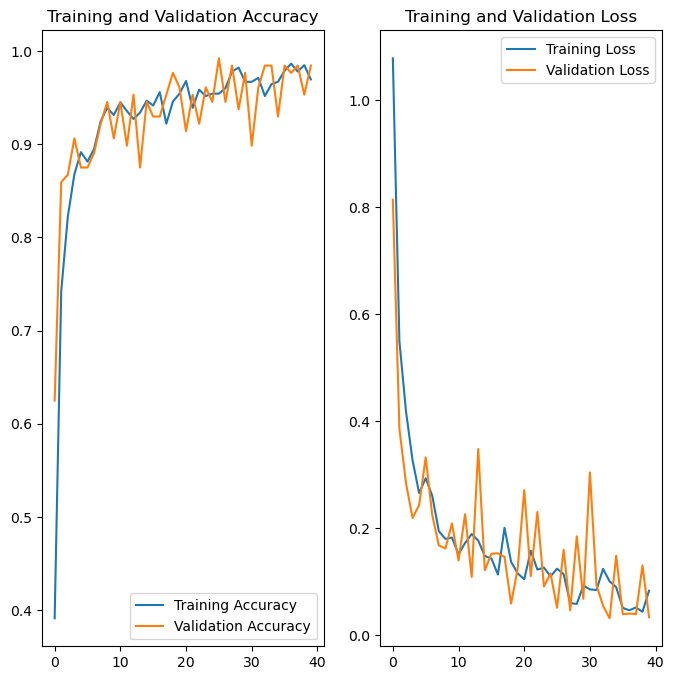

In [20]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [21]:
true_labels = []
pred_labels = []
for images_batch, labels_batch in test_ds.take(6):
    batch_prediction=model.predict(images_batch).argmax(axis=1)
    for i in labels_batch:
        true_labels.append(i)
    for i in batch_prediction:
        pred_labels.append(i)

1/1 [==============================] - 0s 280ms/step


In [22]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 31ms/step


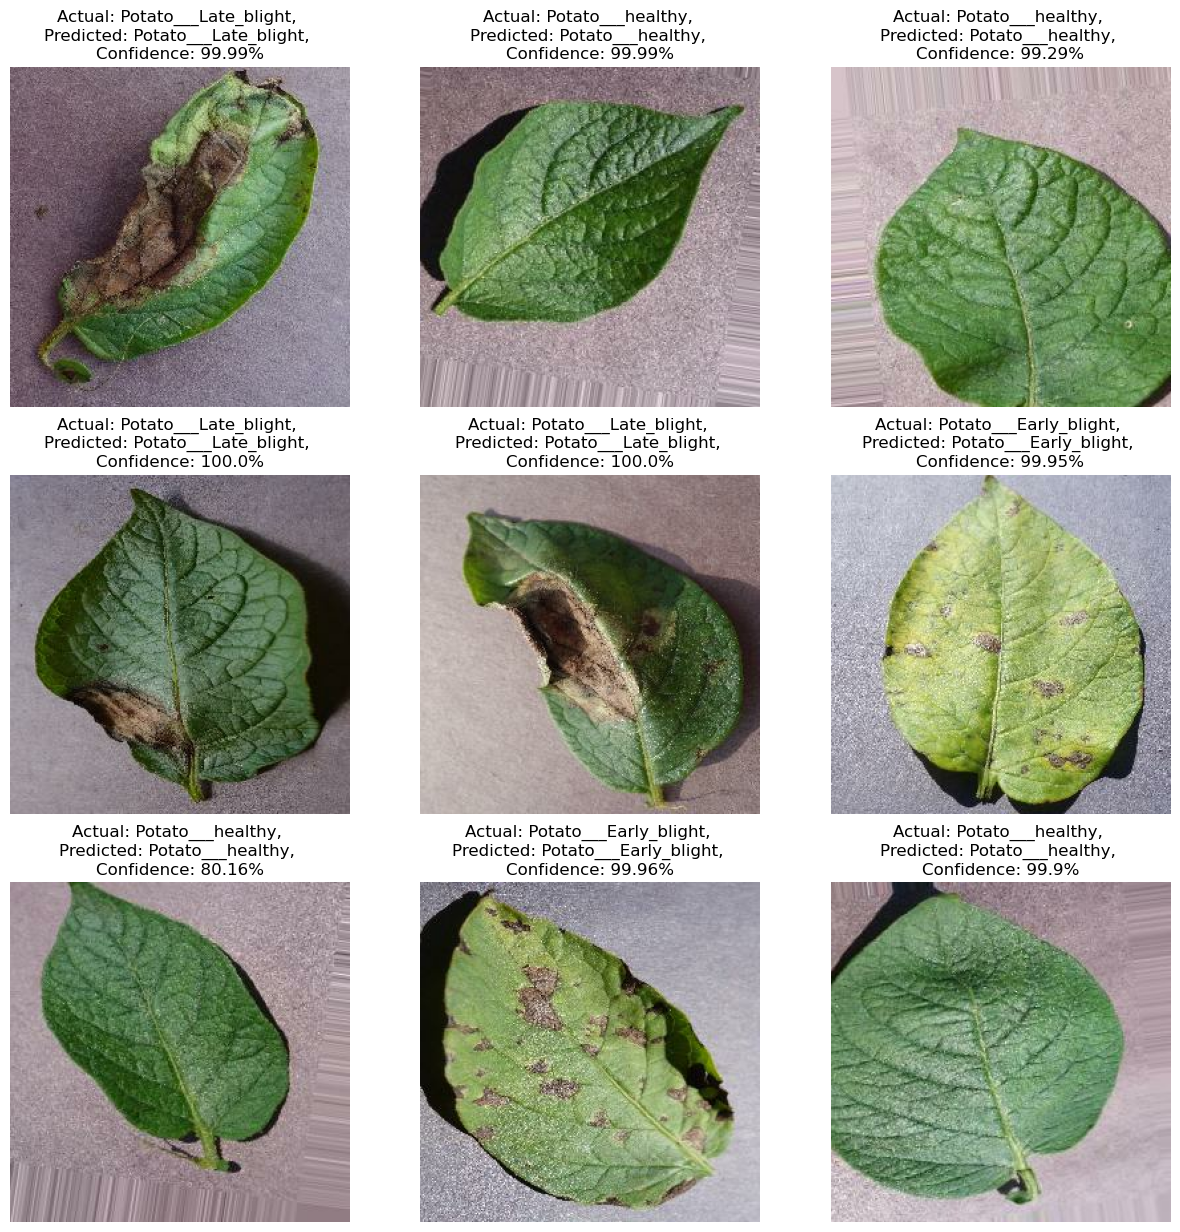

In [23]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")
        plt.axis("off")

In [24]:
print ("Classification Report: \n", classification_report(true_labels, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        62
           1       0.98      0.98      0.98        60
           2       1.00      1.00      1.00        70

    accuracy                           0.99       192
   macro avg       0.99      0.99      0.99       192
weighted avg       0.99      0.99      0.99       192



In [25]:
cm=tf.math.confusion_matrix(true_labels, pred_labels)
cm

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[61,  1,  0],
       [ 1, 59,  0],
       [ 0,  0, 70]])>

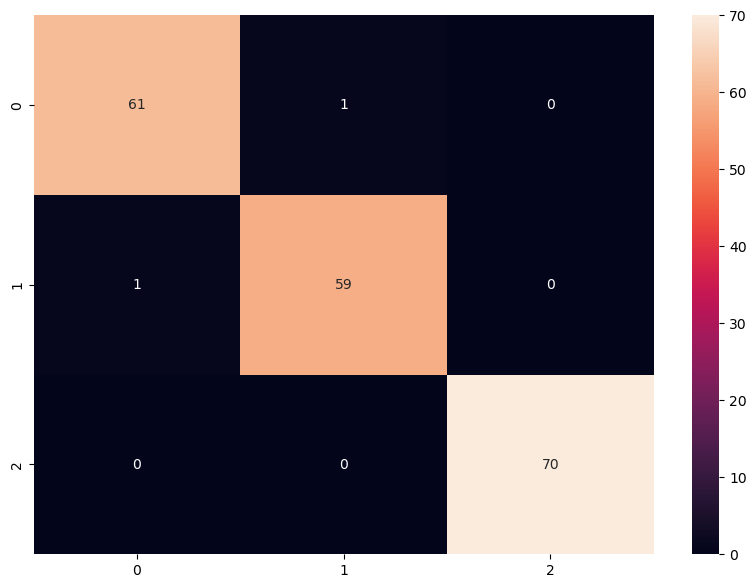

In [26]:
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel=('Predicted')
plt.ylabel=('Truth')

In [27]:
filename = "Model1-2-Epochs40.joblib"
joblib.dump(model, filename)

['Model1-2-Epochs40.joblib']